# Using optimization fitting routines (since v0.3)

New optimization algorithms are introduced in SORA v0.3 to allow faster convergence to the solution when modeling a light curve or fitting an ellipse to the positive chords.

Besides the Monte Carlo technique to find the best solution, there are now two optimization methods available: one, the default option, based on dumped least-squares (Levenberg-Marquardt), and the other based on genetic algorithms (differential evolution).

To maintain backward compatibility with the chi-square result object the estimate of uncertainties still rely on Monte Carlo simulations, but now with parallel processing available.

Two new keywords were added to `sora.LightCurve.occ_lcfit` and to `sora.Occultation.fit_ellipse` functions: `"method"` and `"threads".` The first allows the optimization method selection, while the latter sets the number of parallel processes when using multithreading. The parallel processing relies on the multiprocessing python module, which is built on shared memory parallel processing.

**Methods available:**

- _chisqr_: Monte Carlo computation method used in versions of SORA <= 0.2.1.
- _fastchi_: Monte Carlo computation method, allows multithreading. Used with keyword "threads".
- _least_squares_ or _ls_: uses Levenberg-Marquardt as optimization method.
- _differential_evolution_ or _de_: uses genetic algorithms as optimization method.

## Determining the instants of a light curve using optimization

Let's use the examples available in the Getting Started guide. In the following examples, we will always set the parameter `"threads = 5"`, meaning the number of parallel processes generated during the computations. **It is wise to set the number of threads to a number below the total number of cores available in your CPU (usually n_cores-1) to avoid freezing the computer/interaction during the computations.**

In [1]:
## SORA package
from sora import Occultation, Body, Star, LightCurve, Observer
from sora.prediction import prediction
from sora.extra import draw_ellipse

## Other main packages
from astropy.time import Time
import astropy.units as u

## Usual packages
import numpy as np
import matplotlib.pylab as pl
import os

SORA version: 0.3


Name: Outeniqua lc
Initial time: 2017-06-22 21:20:00.056 UTC
Mean time:    2017-06-22 21:21:40.007 UTC
End time:     2017-06-22 21:23:19.958 UTC
Exposure time: 0.1000 s
Cycle time:    0.1002 s
Vel: 22.0 km/s
Distance: 15.0 AU
Observational wavelength centred at 0.700 with a bandwidth of 0.300 microns
Fresnel Scale: 0.881 km
Stellar diameter: 0.20 km


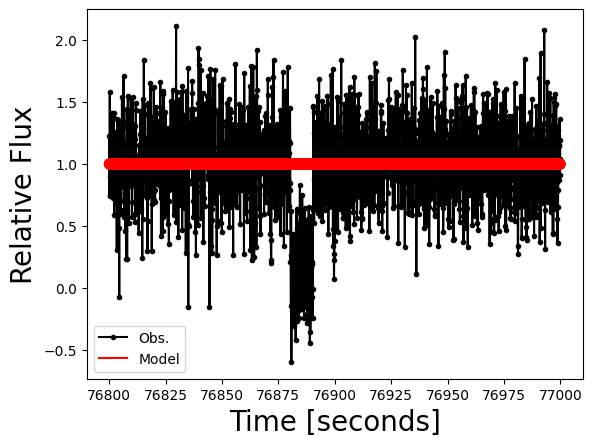

In [2]:
out_lc = LightCurve(name='Outeniqua lc', file='../guidelines/input/lightcurves/lc_example.dat',
                    exptime=0.100, usecols=[0,1])

print('Name: {}'.format(out_lc.name))
print('Initial time: {} UTC'.format(out_lc.initial_time.iso))
print('Mean time:    {} UTC'.format(out_lc.time_mean.iso))
print('End time:     {} UTC'.format(out_lc.end_time.iso))
print('Exposure time: {:.4f} s'.format(out_lc.exptime))
print('Cycle time:    {:.4f} s'.format(out_lc.cycle))

# However, to model a light curve we need to set the shadow/object velocity, object's distance,
# and the star apparend diameter. Let's set some arbitrary values for the sake of example.

out_lc.set_vel(vel=22.0)
print('Vel: {:3.1f} km/s'.format(out_lc.vel))

out_lc.set_dist(dist=15)
print('Distance: {:3.1f} AU'.format(out_lc.dist))

print('Observational wavelength centred at {:1.3f} with a bandwidth of {:1.3f} microns'
      .format(out_lc.central_bandpass,out_lc.delta_bandpass))

print('Fresnel Scale: {:1.3f} km'.format(out_lc.fresnel_scale))

out_lc.set_star_diam(d_star=0.2)
print('Stellar diameter: {:1.2f} km'.format(out_lc.d_star))

out_lc.plot_lc()

In [3]:
# lets autodect the main parameters of the occultation
autodetect = out_lc.occ_detect()
[print('{}: {}'.format(key, value)) for key, value in autodetect.items()]

# and from these results set some initial parameters for our fit
immersion_time = autodetect['immersion_time']
emersion_time = autodetect['emersion_time']
delta_t = autodetect['time_err']*5

rank: 1
occultation_duration: 9.921853244304657
central_time: 76885.2990051359
immersion_time: 76880.33807851374
emersion_time: 76890.25993175805
time_err: 0.05011036992073059
depth: 0.8912593186105263
depth_err: 0.30084243363867164
baseline: 1.0292228832105264
baseline_err: 0.31961412122793376
snr: 2.9625452361583338
occ_mask: [False False False ... False False False]


When using optimization methods ("least_squares" or "differential_evolution") a first run can be done with a smaller value for "loop", since we are interested in the best-fit parameters. After a first run, one can better establish the region around where the Monte Carlos simulations will be sampled to produce much better populated $\chi^2$ maps and therefore more robust uncertainty estimates.

In this first run, we will focus on finding the best fit. Then, we will increase the loop to explore the parameter space around this best fit first found.

Lightcurve fit: |████████████████████████████████████████|  - 100% 


Minimum chi-square: 212.079
Number of fitted points: 200
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 1.071

immersion:
    1-sigma: 76880.329 +/- 0.027
    3-sigma: 76880.363 +/- 0.123

emersion:
    1-sigma: 76890.332 +/- 0.024
    3-sigma: 76890.343 +/- 0.093



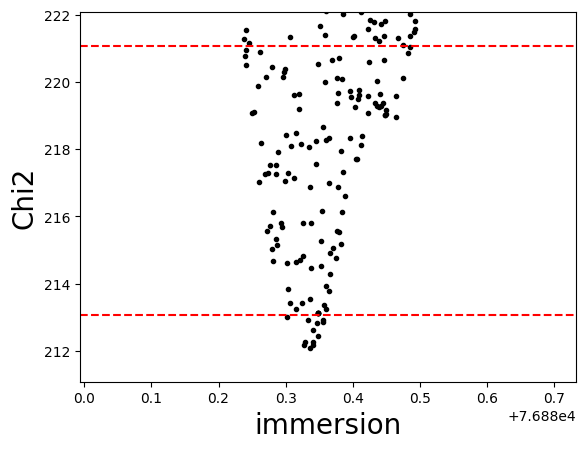

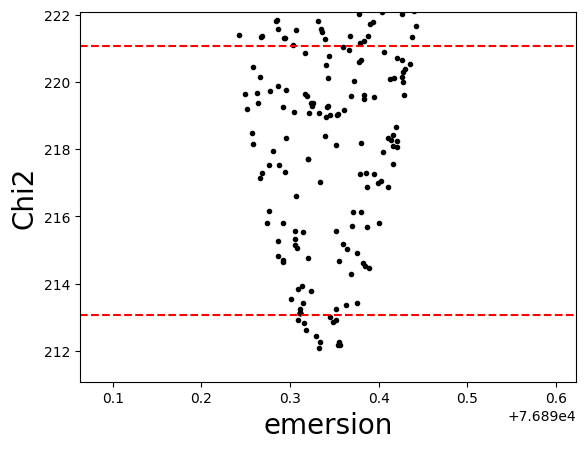

In [4]:
# Here we will set tmax and tmin to use a subset of the data

tmin = immersion_time  - 5 # seconds relative to tref
tmax = emersion_time   + 5 # seconds relative to tref

out_chi2 = out_lc.occ_lcfit(immersion_time=immersion_time, emersion_time=emersion_time, delta_t=delta_t,
                            flux_min=0, flux_max=1, tmax=tmax, tmin=tmin,
                            sigma='auto', sigma_result=1, loop=1000, 
                            method='ls', threads=5)
print('\n')
print(out_chi2)
out_chi2.plot_chi2()

Since the $\chi^2$ maps show we have a good coverage around the minimum, we only need to set the parameter `"loop"` to a higher value in order do produce more confident error bars.

Lightcurve fit: |████████████████████████████████████████|  - 100% 


Minimum chi-square: 212.021
Number of fitted points: 200
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 1.071

immersion:
    1-sigma: 76880.330 +/- 0.027
    3-sigma: 76880.363 +/- 0.124

emersion:
    1-sigma: 76890.341 +/- 0.033
    3-sigma: 76890.339 +/- 0.100



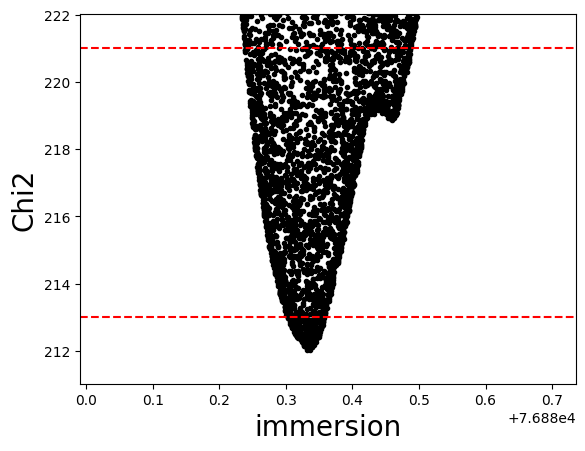

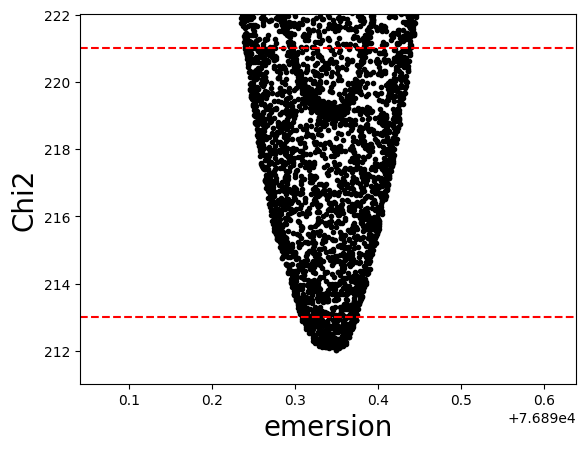

In [5]:
out_chi2 = out_lc.occ_lcfit(immersion_time=immersion_time, emersion_time=emersion_time, delta_t=delta_t,
                            flux_min=0, flux_max=1, tmax=tmax, tmin=tmin,
                            sigma='auto', sigma_result=1, loop=20000, 
                            method='ls', threads=5)
print('\n')
print(out_chi2)
out_chi2.plot_chi2()

And we can produce similar results using the `"differential_evolution"` or `"de"` method.

Lightcurve fit: |████████████████████████████████████████|  - 100% 


Minimum chi-square: 212.042
Number of fitted points: 200
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 1.071

immersion:
    1-sigma: 76880.330 +/- 0.027
    3-sigma: 76880.364 +/- 0.124

emersion:
    1-sigma: 76890.341 +/- 0.033
    3-sigma: 76890.340 +/- 0.100



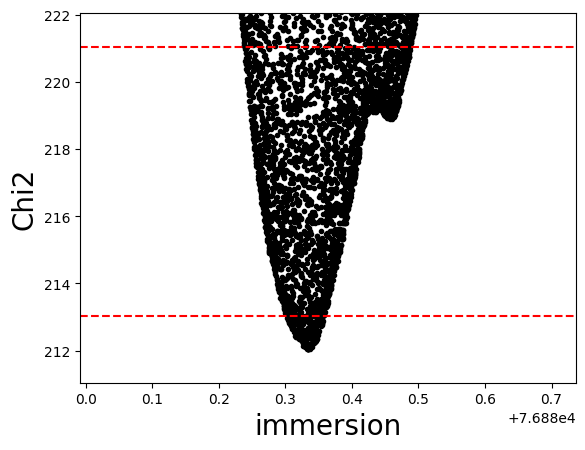

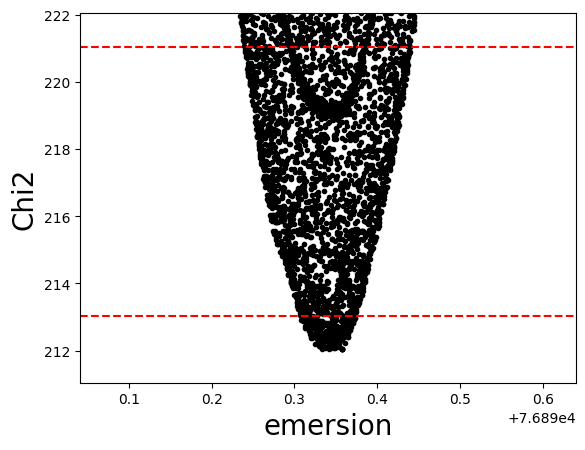

In [6]:
out_chi2 = out_lc.occ_lcfit(immersion_time=immersion_time, emersion_time=emersion_time, delta_t=delta_t,
                            flux_min=0, flux_max=1, tmax=tmax, tmin=tmin,
                            sigma='auto', sigma_result=1, loop=20000, 
                            method='de', threads=5)
print('\n')
print(out_chi2)
out_chi2.plot_chi2()

You can always use the "chiqsr" or "fastchi" if one of the above methods fail. Although more time consuming they will ensure to reach the minimum if there is some failure or trapping during convergence of the previous methods.

Let's check a summary of the results obtained with the last fitting procedure.

Light curve name: Outeniqua lc
Initial time: 2017-06-22 21:20:00.056 UTC
End time:     2017-06-22 21:23:19.958 UTC
Duration:     3.332 minutes
Time offset:  0.000 seconds

Exposure time:    0.1000 seconds
Cycle time:       0.1002 seconds
Num. data points: 2000

Bandpass:             0.700 +/- 0.300 microns
Object Distance:      15.00 AU
Used shadow velocity: 22.000 km/s
Fresnel scale:        0.040 seconds or 0.88 km
Stellar size effect:  0.009 seconds or 0.20 km

Object LightCurve model was not fitted.

Immersion time: 2017-06-22 21:21:20.330 UTC +/- 0.027 seconds
Emersion time:  2017-06-22 21:21:30.341 UTC +/- 0.033 seconds

Monte Carlo chi square fit.

Minimum chi-square: 212.042
Number of fitted points: 200
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 1.071

immersion:
    1-sigma: 76880.330 +/- 0.027
    3-sigma: 76880.364 +/- 0.124

emersion:
    1-sigma: 76890.341 +/- 0.033
    3-sigma: 76890.340 +/- 0.100




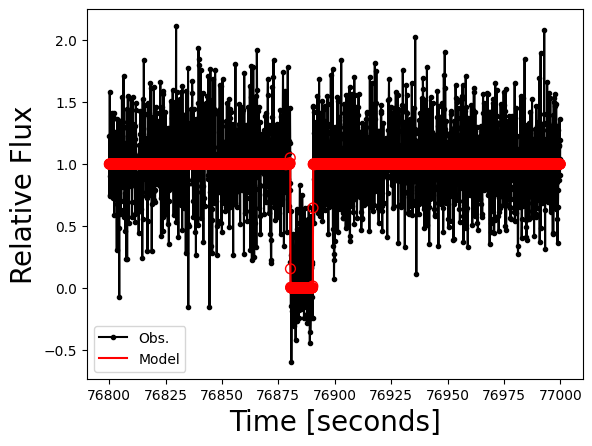

In [7]:
print(out_lc)
out_lc.plot_lc()

## Fitting an ellipse to positive chords using optimization

Again, let's use an examples of the Getting Started guide. In the following examples we will always set the parameter "threads = 5", meaning the number of parallel processes gerenated during the computations. **It is wise to set the number of threads to a number below the total number of cores available in your cpu (usually n_cores-1) to avoid freezing the computer/interaction during the computations.**

In [8]:
# Let's first set up the occultation event 
# and consider an Solar System Body

chariklo = Body(name='Chariklo', 
                ephem=['../guidelines/input/bsp/Chariklo.bsp', '../guidelines/input/bsp/de438_small.bsp'])

# draw the predictions for the epoch of interest
pred = prediction(body=chariklo, time_beg='2017-06-20',time_end='2017-06-27',mag_lim=16)

pred

Obtaining data for Chariklo from SBDB
Ephemeris was split in 1 parts for better search of stars

Searching occultations in part 1/1
Generating Ephemeris between 2017-06-20 00:00:00.000 and 2017-06-26 23:59:00.000 ...
    4 GaiaDR3 stars downloaded
Identifying occultations ...

2 occultations found.


Epoch,ICRS Star Coord at Epoch,Geocentric Object Position,C/A,P/A,Vel,Dist,G,long,loct,M-G-T,S-G-T,GaiaDR3 Source ID
,,,arcsec,deg,km / s,AU,mag,deg,hh:mm,deg,deg,
object,object,object,float64,float64,float64,float64,float64,float64,str5,float64,float64,str19
2017-06-21 09:57:43.440,18 55 36.17454 -31 31 19.03261,18 55 36.17500 -31 31 19.60516,0.573,179.41,-21.84,14.663,15.254,225,00:56,128,165,6760228702284187264
2017-06-22 21:18:48.200,18 55 15.65251 -31 31 21.67062,18 55 15.65249 -31 31 21.62190,0.049,359.72,-22.00,14.659,14.224,53,00:50,149,166,6760223758801661440


In [9]:
# setting up the Star object
star_occ = Star(code='6760223758801661440')

print(star_occ)

1 GaiaDR3 star found band={'G': 14.223702}
star coordinate at J2016.0: RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.018 mas

GaiaDR3 star Source ID: 6760223758801661440
ICRS star coordinate at J2016.0:
RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.0180 mas
pmRA=3.556 +/- 0.025 mas/yr, pmDEC=-2.050 +/- 0.020 mas/yr
GaiaDR3 Proper motion corrected as suggested by Cantat-Gaudin & Brandt (2021) 
Plx=0.2121 +/- 0.0228 mas, Rad. Vel.=-40.49 +/- 3.73 km/s 

Magnitudes: G: 14.224, B: 14.320, V: 13.530, R: 14.180, J: 12.395, H: 11.781,
            K: 11.627

Apparent diameter from Kervella et. al (2004):
    V: 0.0216 mas, B: 0.0216 mas
Apparent diameter from van Belle (1999):
    sg: B: 0.0238 mas, V: 0.0244 mas
    ms: B: 0.0261 mas, V: 0.0198 mas
    vs: B: 0.0350 mas, V: 0.0315 mas


In [10]:
# setting up the Occultation object
occ = Occultation(star=star_occ, body=chariklo, time='2017-06-22 21:18')

print(occ)

Stellar occultation of star GaiaDR3 6760223758801661440 by 10199 Chariklo (1997 CU26).

Geocentric Closest Approach: 0.049 arcsec
Instant of CA: 2017-06-22 21:18:48.200
Position Angle: 359.72 deg
Geocentric shadow velocity: -22.00 km / s
Sun-Geocenter-Target angle:  166.42 deg
Moon-Geocenter-Target angle: 149.11 deg


No observations reported

###############################################################################
                                     STAR                                      
###############################################################################
GaiaDR3 star Source ID: 6760223758801661440
ICRS star coordinate at J2016.0:
RA=18h55m15.65210s +/- 0.0197 mas, DEC=-31d31m21.6676s +/- 0.0180 mas
pmRA=3.556 +/- 0.025 mas/yr, pmDEC=-2.050 +/- 0.020 mas/yr
GaiaDR3 Proper motion corrected as suggested by Cantat-Gaudin & Brandt (2021) 
Plx=0.2121 +/- 0.0228 mas, Rad. Vel.=-40.49 +/- 3.73 km/s 

Magnitudes: G: 14.224, B: 14.320, V: 13.530, R: 14.180, J: 12.395, H:

In [11]:
# defining the observers and their lat, lon, and height information

out = Observer(name='Outeniqua'  ,lon='+16 49 17.710', lat='-21 17 58.170', height =1416)
ond = Observer(name='Onduruquea' ,lon='+15 59 33.750', lat='-21 36 26.040', height =1220)
tiv = Observer(name='Tivoli'     ,lon='+18 01 01.240', lat='-23 27 40.190', height =1344)
whc = Observer(name='Windhoek'   ,lon='+17 06 31.900', lat='-22 41 55.160', height =1902)
hak = Observer(name='Hakos'      ,lon='+16 21 41.320', lat='-23 14 11.040', height =1843)

In [12]:
# Here we are defining each occultation light curve mannualy. 
# However, having the data, one can use the fitting methods 
# shown above to find the occultation instants and its errors.

out_lc = LightCurve(name='Outeniqua lc',
                    initial_time='2017-06-22 21:20:00.056',
                    end_time ='2017-06-22 21:29:59.963',
                    immersion='2017-06-22 21:21:20.329',immersion_err=0.320,
                    emersion ='2017-06-22 21:21:30.343',emersion_err=0.340)

ond_lc = LightCurve(name='Onduruquea lc',
                    initial_time='2017-06-22 21:11:52.175',
                    end_time ='2017-06-22 21:25:13.389',
                    immersion='2017-06-22 21:21:22.213',immersion_err=0.100,
                    emersion ='2017-06-22 21:21:33.824',emersion_err=0.110)

tiv_lc = LightCurve(name='Tivoli lc',
                    initial_time='2017-06-22 21:16:00.094',
                    end_time ='2017-06-22 21:28:00.018',
                    immersion='2017-06-22 21:21:15.628',immersion_err=0.700,
                    emersion ='2017-06-22 21:21:19.988',emersion_err=0.700)

whc_c14_lc = LightCurve(name='Windhoek C14 lc',
                    initial_time='2017-06-22 21:12:48.250',
                    end_time ='2017-06-22 21:32:47.963',
                    immersion='2017-06-22 21:21:17.609',immersion_err=0.240,
                    emersion ='2017-06-22 21:21:27.564',emersion_err=0.260)

whc_d16_lc = LightCurve(name='Windhoek D16 lc',
                    initial_time='2017-06-22 21:20:01.884',
                    end_time ='2017-06-22 21:22:21.894',
                    immersion='2017-06-22 21:21:17.288',immersion_err=0.280,
                    emersion ='2017-06-22 21:21:27.228',emersion_err=0.340)

hak_lc = LightCurve(name='Hakos lc',
                    initial_time='2017-06-22 21:10:19.461',
                    end_time ='2017-06-22 21:30:19.345')

In [13]:
# Now we will add the defined instants as chords to the occultation object

occ.chords.add_chord(observer=out, lightcurve=out_lc)
occ.chords.add_chord(observer=ond, lightcurve=ond_lc)
occ.chords.add_chord(observer=tiv, lightcurve=tiv_lc)
occ.chords.add_chord(name='Windhoek C14', observer=whc, lightcurve=whc_c14_lc)
occ.chords.add_chord(name='Windhoek D16', observer=whc, lightcurve=whc_d16_lc)
occ.chords.add_chord(observer=hak, lightcurve=hak_lc)


# And fix some of the time offsets measured for each light curve.
# (This information is provided by the observers, usually due to GPS time precision)
out_lc.dt = -0.150
ond_lc.dt = -0.190
tiv_lc.dt = -0.150
whc_c14_lc.dt = -0.375
whc_d16_lc.dt = +0.000

/mnt/data/repos/SORA/sora/body/core.py:332: UserWarning: H and/or G is not defined for 10199 Chariklo. Searching into JPL Horizons service
  warnings.warn('H and/or G is not defined for {}. Searching into JPL Horizons service'.format(self.shortname))


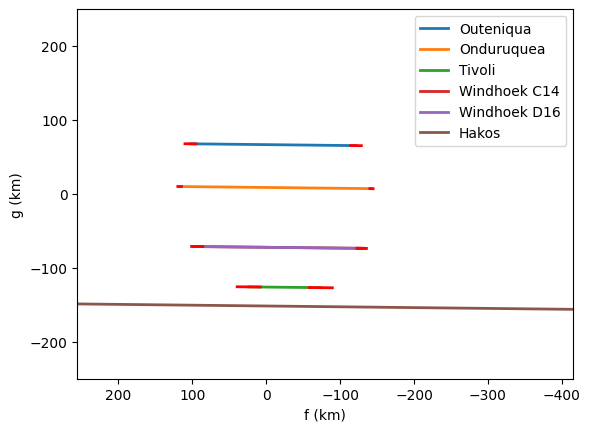

In [14]:
# plotting the added chords
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()

To fit an ellipse to the data, as before, we will set a small value for the `"number_chi"` variable (which plays a role similar to `"loop"` in the light curve fit)  since we first want only a best-fit value obtained with the convergence methods.

Ellipse fit: |████████████████████████████████████████|  - 100% 
Total elapsed time: 7.595 seconds.
Minimum chi-square: 0.062
Number of fitted points: 10
Number of fitted parameters: 5
Minimum chi-square per degree of freedom: 0.012

center_f:
    1-sigma: -13.624 +/- 0.000
    3-sigma: -13.515 +/- 3.227

center_g:
    1-sigma: -2.240 +/- 0.000
    3-sigma: 2.264 +/- 14.672

equatorial_radius:
    1-sigma: 138.043 +/- 0.000
    3-sigma: 145.778 +/- 17.264

oblateness:
    1-sigma: 0.082 +/- 0.000
    3-sigma: 0.113 +/- 0.113

position_angle:
    1-sigma: 125.073 +/- 0.000
    3-sigma: 117.883 +/- 79.834



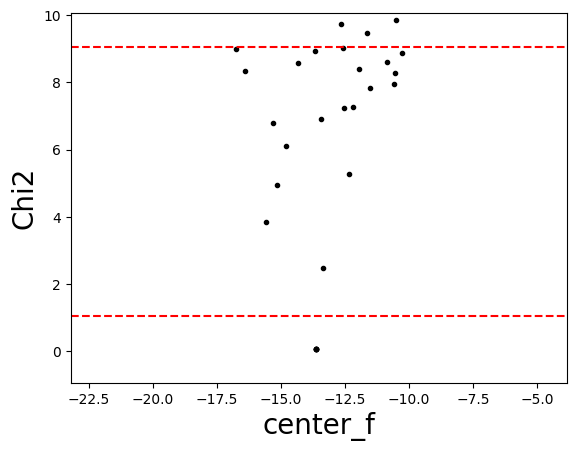

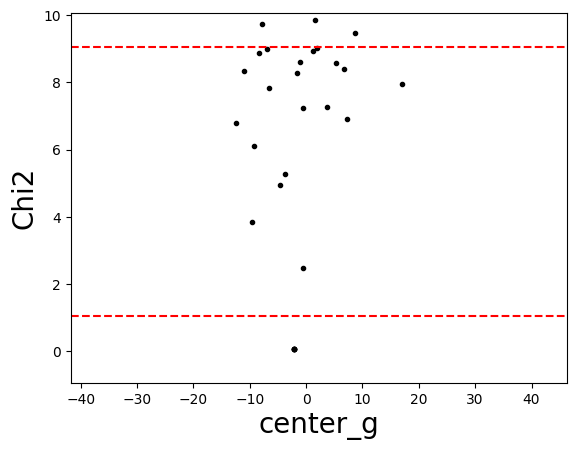

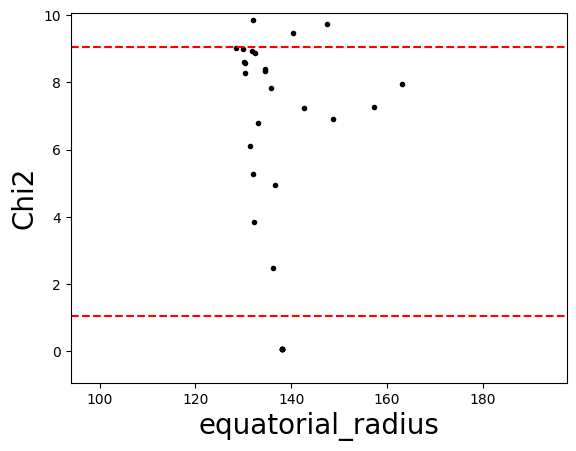

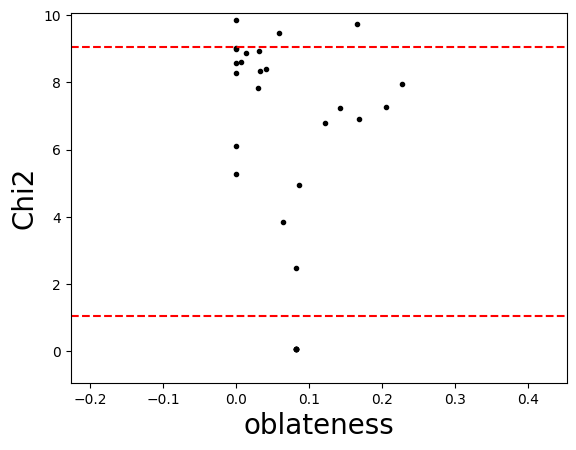

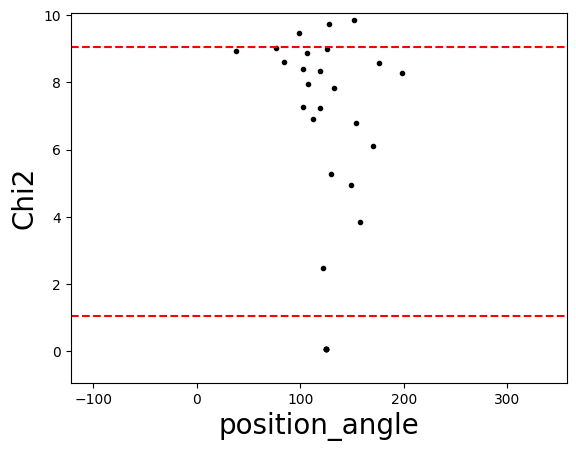

In [15]:
### If this still takes to long to run, reduce the number_chi value

ellipse_chi2  = occ.fit_ellipse(center_f=0, center_g=0, dcenter_f=500, dcenter_g=500, 
                                equatorial_radius=200, dequatorial_radius=200, oblateness=0.0, 
                                doblateness=0.2, position_angle=90, dposition_angle=90,
                                dchi_min=10, number_chi=2500, method='ls', threads=5, verbose=True)


# print the best fit variables
print(ellipse_chi2)

# print the chi-square maps
ellipse_chi2.plot_chi2()

Knowing better the region of the minima for the parameters and having a coarse approximation their the 3-sigma boundaries, we can now set a larger value for the `"number_chi"` variable and explore more efficiently the space parameter.

Ellipse fit: |████████████████████████████████████████|  - 100% 
Total elapsed time: 5.022 seconds.
Minimum chi-square: 0.062
Number of fitted points: 10
Number of fitted parameters: 5
Minimum chi-square per degree of freedom: 0.012

center_f:
    1-sigma: -13.617 +/- 1.317
    3-sigma: -13.572 +/- 4.442

center_g:
    1-sigma: -2.349 +/- 4.639
    3-sigma: 2.609 +/- 19.447

equatorial_radius:
    1-sigma: 138.215 +/- 4.864
    3-sigma: 153.012 +/- 25.587

oblateness:
    1-sigma: 0.085 +/- 0.033
    3-sigma: 0.141 +/- 0.141

position_angle:
    1-sigma: 131.015 +/- 23.334
    3-sigma: 125.085 +/- 89.974



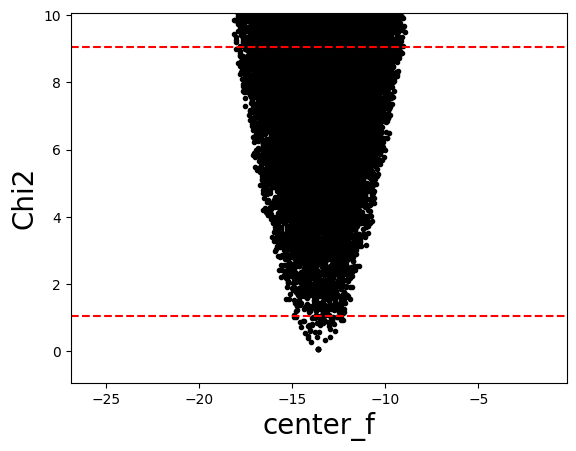

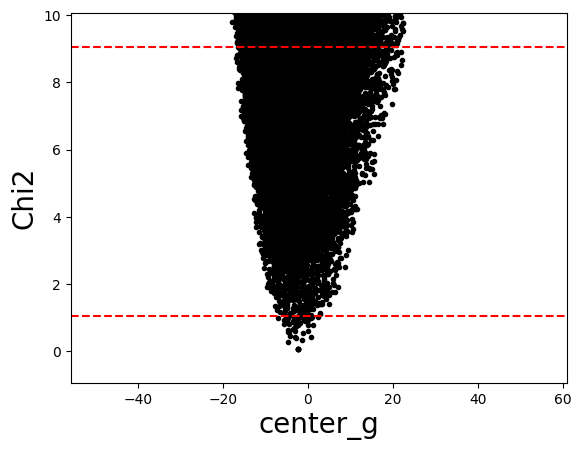

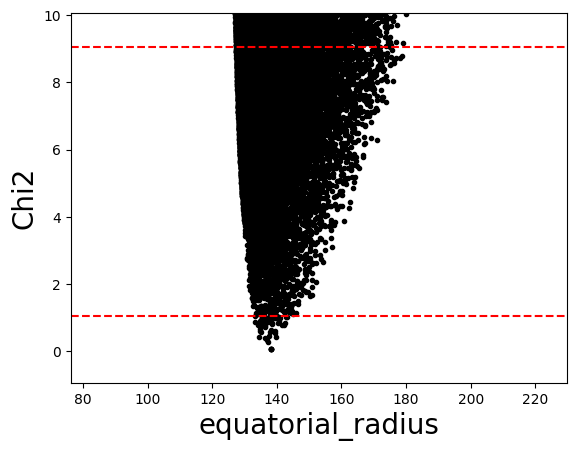

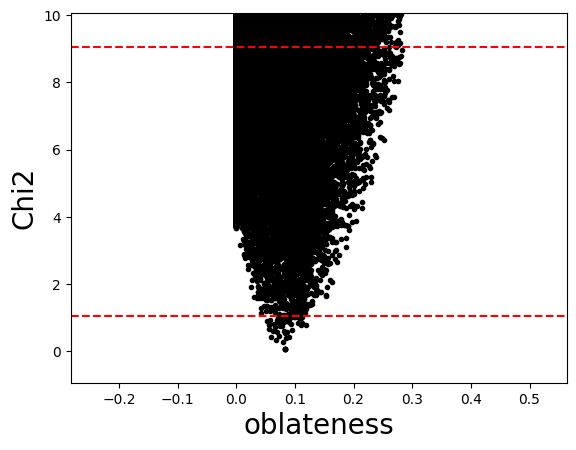

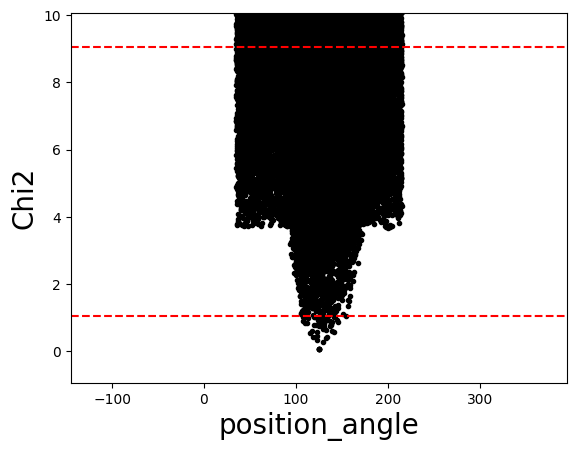

In [16]:
ellipse_chi2  = occ.fit_ellipse(center_f=-13.6, center_g=-2.2, dcenter_f=25, dcenter_g=25, 
                                equatorial_radius=138, dequatorial_radius=50, oblateness=0.08, 
                                doblateness=0.2, position_angle=125, dposition_angle=90 ,
                                dchi_min=10, number_chi=50000, method='ls', threads=5, verbose=True)


# print the best fit variables
print(ellipse_chi2)

# print the chi-square maps
ellipse_chi2.plot_chi2()

Let's finally plot our solution and the region of uncertainties around this best set of parameters.

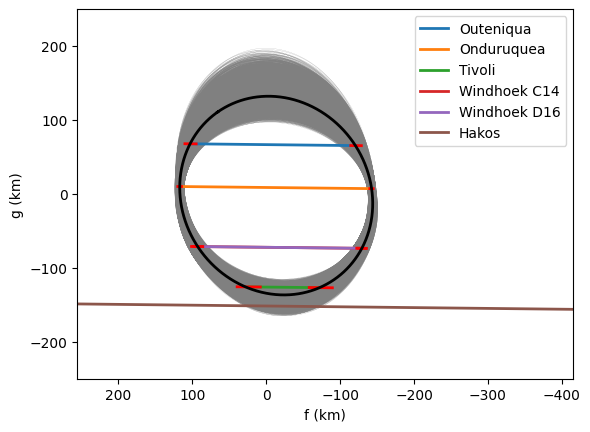

In [17]:
occ.chords.plot_chords()
occ.chords.plot_chords(segment='error', color='red')

#plotting the best fitted ellipse, in black
draw_ellipse(**ellipse_chi2.get_values())

# ploting all the ellipses within 3-sigma, in gray
draw_ellipse(**ellipse_chi2.get_values(sigma=3),alpha=1.0)

pl.legend(loc=1)
pl.xlim(+170,-330)
pl.ylim(-250,+250)
pl.show()